# t-test between cue and read
1. baseline：cue前的(0, 0.75), 统一cue和read为一个baseline
2. average：分别将cue和read的samples平均，得到一个shape为（n_timesteps, n_frequencies）的数据
3. plot：分别绘制cue和read的频谱图
4. t-test：逐点计算cue和read的显著性

In [1]:
import numpy as np
from ecog_band.utils import *
import pandas as pd
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from ecog_band.datasetAllband import SVMDataset
from ecog_band.models import SVMBinClassifier
import os
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from ecog_band.utils import *
from ecog_band.solver import Nfold_solver
import pandas as pd
# from ecog_band.datasetExcludeBand import CustomDatasetExcband
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

freq = 500
HS = 69
elec = 74

path_elec = f'/public/DATA/overt_reading/dataset_/HS{HS}/{freq}/{elec}'
num_samples = len(os.listdir(path_elec))

/root/pp/covert-reading/Ecog_pretrain/ecog_band/solver.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # may raise warning about Jupyter


In [15]:
def expanded_data(data, expand_size):# 扩展baseline数据
    data_0 = data[0]
    expanded_data_0 = np.expand_dims(data_0, axis=0)
    expanded_data = np.tile(expanded_data_0, (expand_size, 1, 1))
    return expanded_data

In [19]:
data_read = []
data_cue = []
baseline_data = []

for num in range(num_samples): # num为块的个数
    cue_path = os.path.join(path_elec, f'{num}_data_block_cue.npy')
    read_path = os.path.join(path_elec, f'{num}_data_block_read.npy')
    baseline_path = os.path.join(path_elec, f'{num}_baseline_block_cue.npy')
    # print(cue_path)
    if os.path.exists(cue_path) and os.path.exists(read_path):
        elec_cue = np.load(cue_path) # (n_task, n_freq, n_timePoint) (60, 501, 375)
        elec_read = np.load(read_path)
        elec_base = np.load(baseline_path)

        data_cue.append(elec_cue)
        data_read.append(elec_read)
        baseline_data.append(expanded_data(elec_base, len(elec_cue)))


data_cue=np.abs(np.vstack(data_cue))
data_read=np.abs(np.vstack(data_read))
baseline_data=np.abs(np.vstack(baseline_data))

print(data_cue.shape)
print(data_read.shape)
print(baseline_data.shape)

#average
cue_mean = np.mean(data_cue, axis=0)
read_mean = np.mean(data_read, axis=0)
print(cue_mean.shape)
print(read_mean.shape)


(360, 501, 375)
(360, 501, 375)
(360, 501, 375)
(501, 375)
(501, 375)


In [9]:
def plt_tf(stft_data, title, ax):
    n_freqs = stft_data.shape[0]
    freqs = np.linspace(0, 500, stft_data.shape[0])
    step = max(1, n_freqs // 10)  # 选择每隔多少个频率 bin 显示一个刻度
    ticks = np.arange(0, n_freqs, step)
    labels = [f'{freqs[i]:.1f}' for i in ticks]
    # plt.figure(figsize=(12, 6))
    cax  = ax.imshow(stft_data, aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Time-Frequency - {title}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)

    return cax

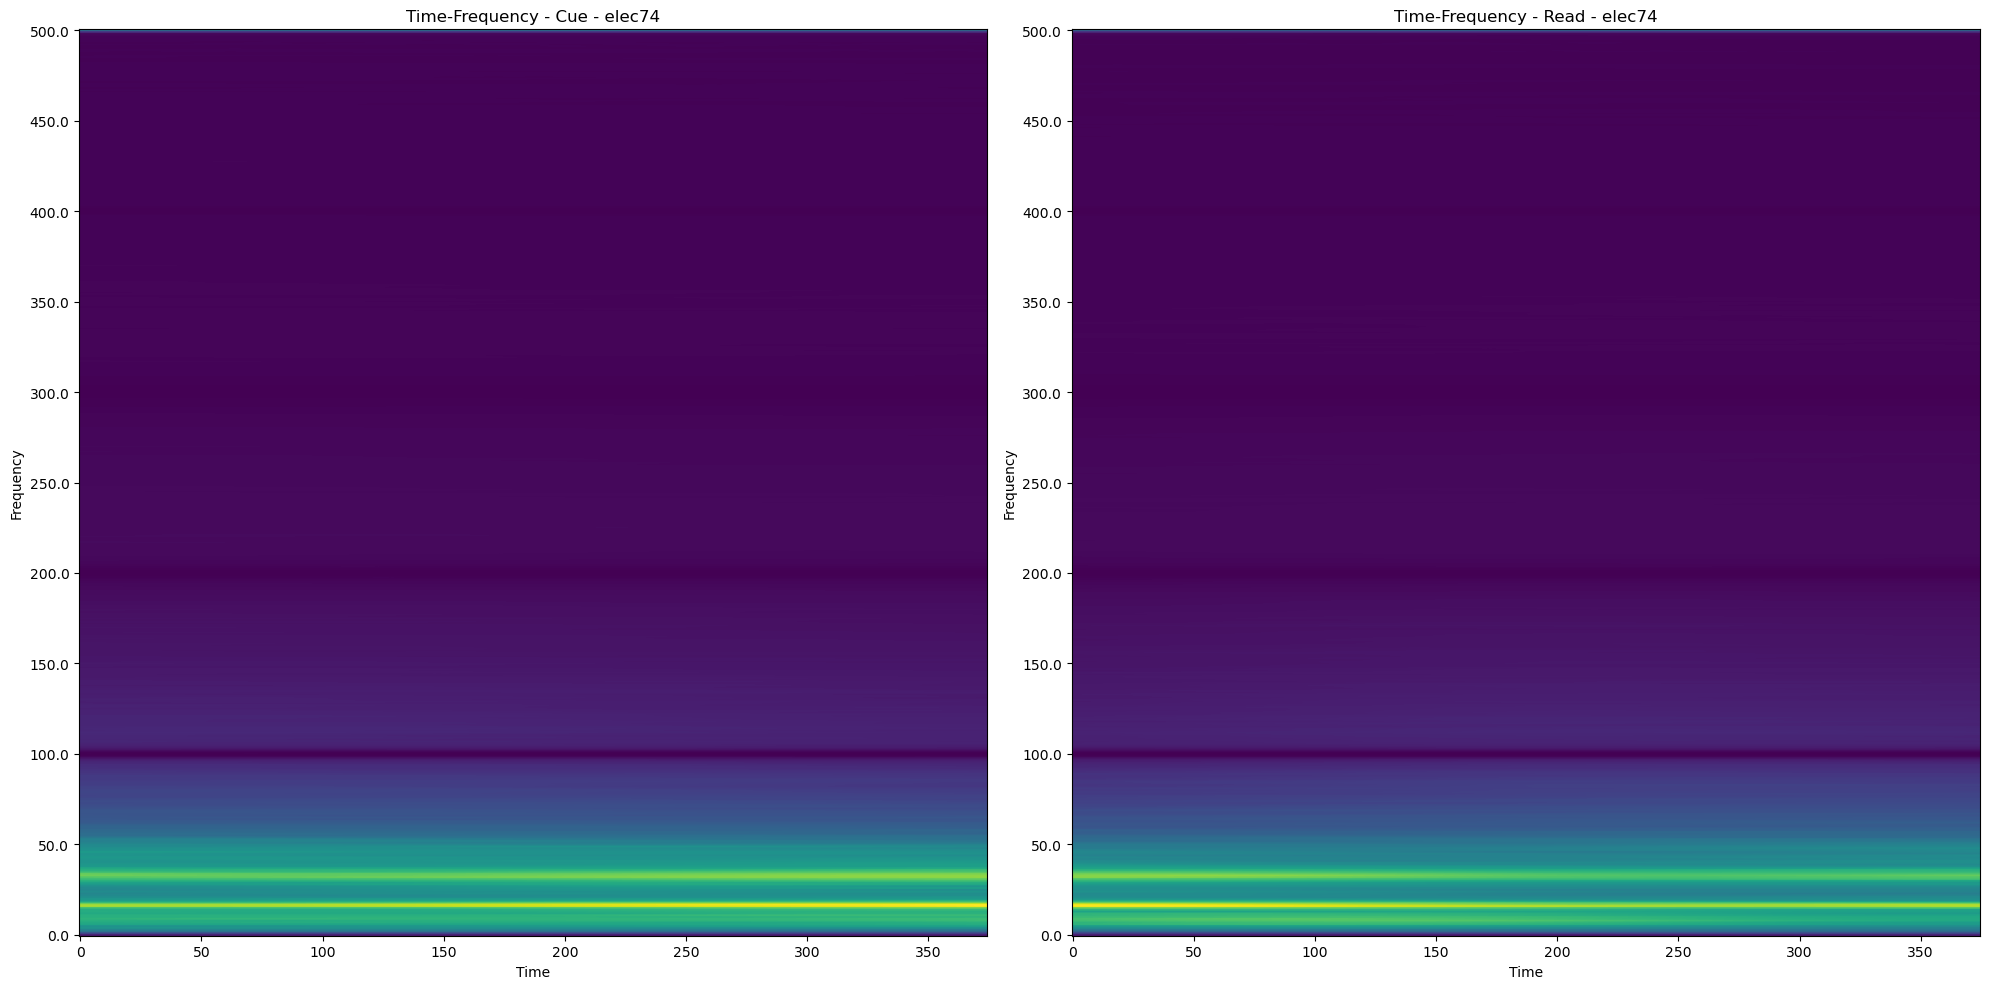

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
cax_cue = plt_tf(cue_mean, f'Cue - elec{elec}', axs[0])
cax_read = plt_tf(read_mean, f'Read - elec{elec}', axs[1])
plt.tight_layout()
plt.show()

In [11]:
# t_test
n_frequency, n_times = data_cue[0].shape

print(data_cue.shape, data_read.shape)
print(np.isnan(data_cue).sum(), np.isnan(data_read).sum())
from scipy import stats
import numpy as np

# 存储 p 值矩阵
p_values = np.zeros((n_frequency, n_times))
f_values = np.zeros((n_frequency, n_times))
for f in range(n_frequency):
    for t in range(n_times):
        cue_vals = data_cue[:, f, t]
        read_vals = data_read[:, f, t]
        
        if np.std(cue_vals) > 0 and np.std(read_vals) > 0:
            f_val, p_val = stats.ttest_ind(cue_vals, read_vals, equal_var=False)
            p_values[f, t] = p_val
            f_values[f, t] = f_val
        else:
            p_values[f, t] = np.nan
            f_values[f, t] = np.nan

(360, 501, 375) (360, 501, 375)
0 0


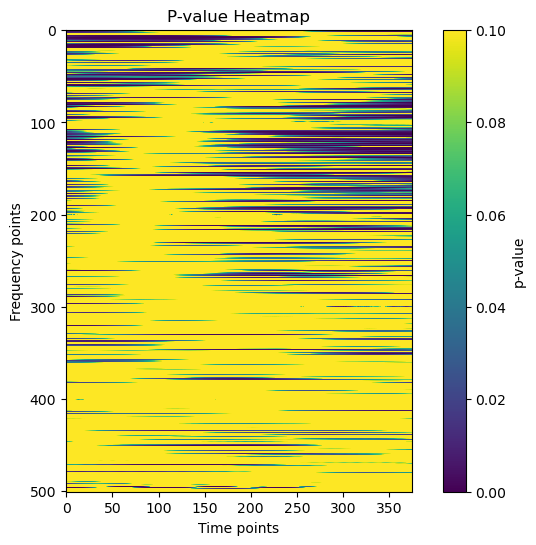

In [12]:
plt.figure(figsize=(8, 6))
plt.imshow(p_values, cmap='viridis', interpolation='nearest', vmin=0, vmax=0.1)
plt.colorbar(label='p-value')
plt.title('P-value Heatmap')
plt.xlabel('Time points')
plt.ylabel('Frequency points')
plt.show()

In [21]:
# z-score before t-test
def z_score_standardize(X, X_base):
    """计算 z-score 标准化"""
    mean_X = np.mean(X_base, axis=0)  # 计算基线数据的均值
    std_X = np.std(X_base, axis=0)    # 计算基线数据的标准差
    return (X - mean_X) / std_X

In [24]:
data_cue_norm = z_score_standardize(data_cue, baseline_data)
data_read_norm = z_score_standardize(data_read, baseline_data)
cue_mean = np.mean(data_cue_norm, axis=0)
read_mean = np.mean(data_read_norm, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
cax_cue = plt_tf(cue_mean, f'Cue - elec{elec}', axs[0])
cax_read = plt_tf(read_mean, f'Read - elec{elec}', axs[1])
plt.tight_layout()
plt.show()